In [1]:
import os
import sys
#sys.path.insert(0, os.path.dirname(os.getcwd()))
import pickle

import numpy as np
import torch
#import torch.cuda
import timeit
import pandas as pd
#import argparse
import itertools
from load_data import load_data # segment_SHAP
from evaluation.metrics.opposite_class import Opposite_Class
from models.predictor_utils import load_predictor
from pickle import dump



In [2]:
# PATHS
datasets_folder_path = None
attributions_folder_path = None
trained_models_folder_path = None
save_results_folder_path = None

In [8]:
# settings
dataset_names = ['UWAVE', "KeplerLightCurves", "MP8", "gunpoint", "EOG"] 
predictor_names = ["randomForest", 'miniRocket', 'resNet', "QUANT"]
segmentation_names = ["clasp","greedygaussian", "equal", "infogain","nnsegment"] # ["clasp","greedygaussian", "equal", "infogain","nnsegment"] 
background_names =  ["average", "zero","sampling"] #["average", "zero", "sampling"]
normalization_names = ["default", "normalized"]

metric_names = ["opposite_class"]
metric_name = metric_names[0]

demo_mode = False
demo_mode_samples = 25
# demo
if demo_mode:
    dataset_names = ['UWAVE']
    predictor_names = ['resNet'] #['randomForest', 'resNet', 'miniRocket']
    segmentation_names = ['nnsegment']
    background_names = ["average"]#, 'zero','sampling']
    normalization_names = ["default", "normalized"]

# optional
# # get infos about which explanations are evaluated
# datasets = list( explanations['attributions'].keys() )
# segmentations = list( explanations['attributions'][datasets[0]].keys() )
# predictors = list( explanations['attributions'][datasets[0]][segmentations[0]].keys() )
# backgrounds = list( explanations['attributions'][datasets[0]][segmentations[0]][predictors[0]].keys() )
# result_types = ['default','normalized']

In [9]:
# column_names = ['Dataset', 'Segmentation', 'ML model', 'Background', 'Normalization', 'Metric', 'Perturb', "Result"]
# df = pd.DataFrame(data=data_list, columns = column_names)

In [10]:
# df

In [11]:
df_list = []

In [12]:
cwd = os.getcwd()
if datasets_folder_path is None:
    datasets_folder_path = "datasets" #os.path.join(cwd, "datasets")
if attributions_folder_path is None:
    attributions_folder_path = "attributions"
if trained_models_folder_path is None:
    trained_models_folder_path = "trained_models"
if save_results_folder_path is None:
    save_results_folder_path = os.path.join("evaluation", "opposite_class_results")

# device
device = "cuda" if torch.cuda.is_available() else "cpu"

starttime = timeit.default_timer()

eval_metrics = dict.fromkeys(metric_names)
for key in eval_metrics:
    if key=="opposite_class":
        eval_metrics[key] = Opposite_Class()
    else:
        raise KeyError(f"key {key} has no corresponding eval metric defined")

for dataset_name in dataset_names:
    print("Dataset: ", dataset_name)
    # loading dataset
    X_train, X_test, y_train, y_test, enc = load_data(subset='all', dataset_name=dataset_name, path=datasets_folder_path)
    if demo_mode:
        X_test, y_test = X_test[:demo_mode_samples], y_test[:demo_mode_samples]

    for eval_metric in eval_metrics.values():
        eval_metric.fit_data(X_train, X_test, y_train, y_test)

    for predictor_name in predictor_names:
        print("Predictor: ", predictor_name)

        # load classifier
        predictor = load_predictor(path=trained_models_folder_path, predictor_name=predictor_name, dataset_name=dataset_name, device=device) # torch.device(device)

        # load explanations
        attribution_filename = "_".join(("all_results", dataset_name, predictor_name)) + ".npy"
        explanations = np.load(os.path.join(attributions_folder_path, attribution_filename), allow_pickle=True).item() # FileNotFoundError
        label_mapping = explanations['label_mapping'][dataset_name]

        for eval_metric in eval_metrics.values():
            eval_metric.fit_ml_model(predictor)
        
        y_test_pred = explanations['y_test_pred'][dataset_name][predictor_name]

        data_list = []

        eval_metric = eval_metrics[metric_name]
        results = eval_metric.evaluate()

        for result_tuple in results:
            data_list.append((dataset_name, predictor_name, metric_name) + result_tuple)

        print("elapsed time", (timeit.default_timer() - starttime))

        # save
        column_names = ['Dataset', 'ML model', 'Metric', 'Perturb', "Result"]
        df = pd.DataFrame(data=data_list, columns = column_names)
        file_name = "_".join(("evaluation", predictor_name, dataset_name))
        result_path = os.path.join(save_results_folder_path, file_name)
        df_list.append(df)
        if not demo_mode:
            df.to_csv(result_path)
            # with open( "_".join( (dataset_name,classifier_name)) ,"wb") as f:
            #     pickle.dump(results_dict, f)

Dataset:  UWAVE
Predictor:  randomForest
elapsed time 2.3889974000048824
Predictor:  miniRocket
elapsed time 2.5780159999994794
Predictor:  resNet
elapsed time 2.7517233999969903
Predictor:  QUANT
elapsed time 4.664869300002465
Dataset:  KeplerLightCurves
Predictor:  randomForest
elapsed time 8.283758899997338
Predictor:  miniRocket
elapsed time 8.913937899997109
Predictor:  resNet
elapsed time 11.11924220000219
Predictor:  QUANT
elapsed time 12.899633499997435
Dataset:  MP8
Predictor:  randomForest
elapsed time 13.350065699996776
Predictor:  miniRocket
elapsed time 13.631471200002125
Predictor:  resNet
elapsed time 13.979218099993886
Predictor:  QUANT
elapsed time 15.032555800004047
Dataset:  gunpoint
Predictor:  randomForest
elapsed time 15.195680200005881
Predictor:  miniRocket
elapsed time 15.254637300007744
Predictor:  resNet
elapsed time 15.36535599999479
Predictor:  QUANT
elapsed time 15.721995400002925
Dataset:  EOG
Predictor:  randomForest
elapsed time 16.978302699993947
Predi

In [15]:
df = pd.concat(df_list).reset_index()
df

,index,Dataset,ML model,Metric,Perturb,Result
0,0,UWAVE,randomForest,opposite_class,mean,0.066250
1,1,UWAVE,randomForest,opposite_class,std,0.064795
2,0,UWAVE,miniRocket,opposite_class,mean,0.115240
3,1,UWAVE,miniRocket,opposite_class,std,0.074061
4,0,UWAVE,resNet,opposite_class,mean,0.128114
5,1,UWAVE,resNet,opposite_class,std,0.329403
6,0,UWAVE,QUANT,opposite_class,mean,0.088750
7,1,UWAVE,QUANT,opposite_class,std,0.053312
8,0,KeplerLightCurves,randomForest,opposite_class,mean,0.135714
9,1,KeplerLightCurves,randomForest,opposite_class,std,0.122574


In [16]:
import matplotlib.pyplot as plt

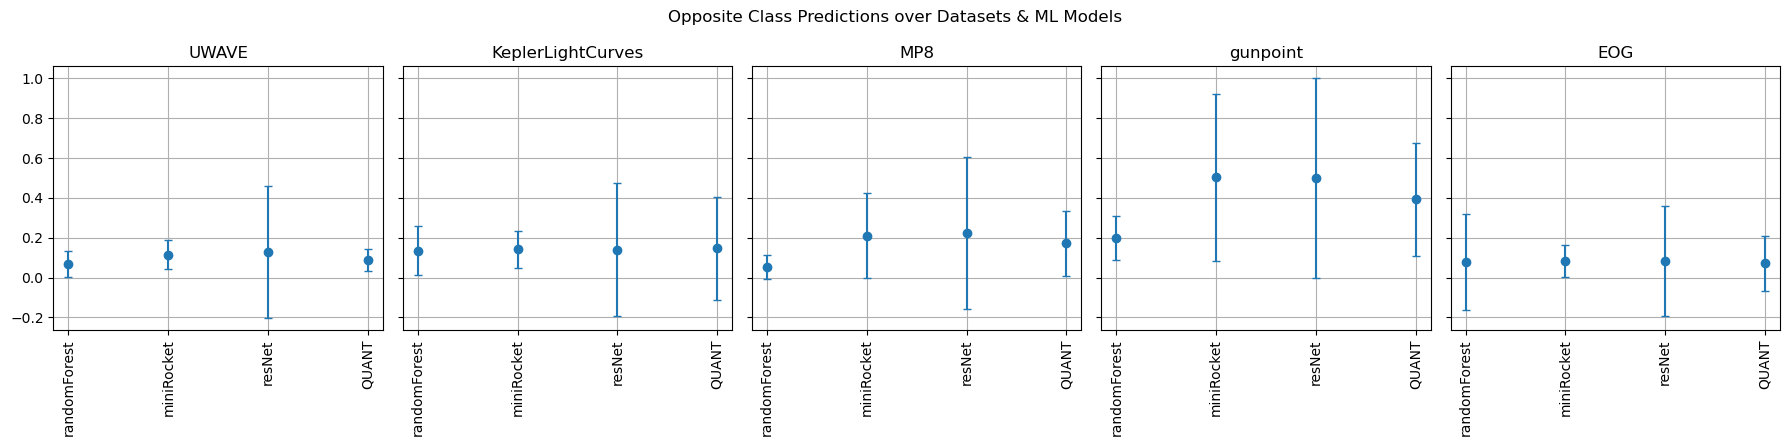

In [24]:
dataset_names = df["Dataset"].unique()
ml_model_names = df['ML model'].unique()

mask = (df["Metric"]=="opposite_class")
df2 = df.loc[mask, ["Dataset", "ML model", "Perturb", "Result"]]

fig, ax = plt.subplots(1, len(dataset_names), figsize = (18,4.5), sharex=False, sharey=True)

for i, dataset_name in enumerate(dataset_names):

    mask = (df2["Dataset"]==dataset_name)
    df3 = df2.loc[mask, ["ML model", "Perturb", "Result"]]
    ax[i].set_title(dataset_name)

    mask = (df3["Perturb"]=="mean")
    df4 = df3.loc[mask, ["ML model", "Result"]]

    x = df4["ML model"].values
    y = df4["Result"].values

    mask = (df3["Perturb"]=="std")
    df5 = df3.loc[mask, ["ML model", "Result"]]
    e = df5["Result"].values

    ax[i].errorbar(x, y, e, linestyle='None', marker='o', capsize=3)
    ax[i].grid()
    ax[i].tick_params("x", rotation=90)

fig.suptitle("Opposite Class Predictions over Datasets & ML Models")
fig.tight_layout()